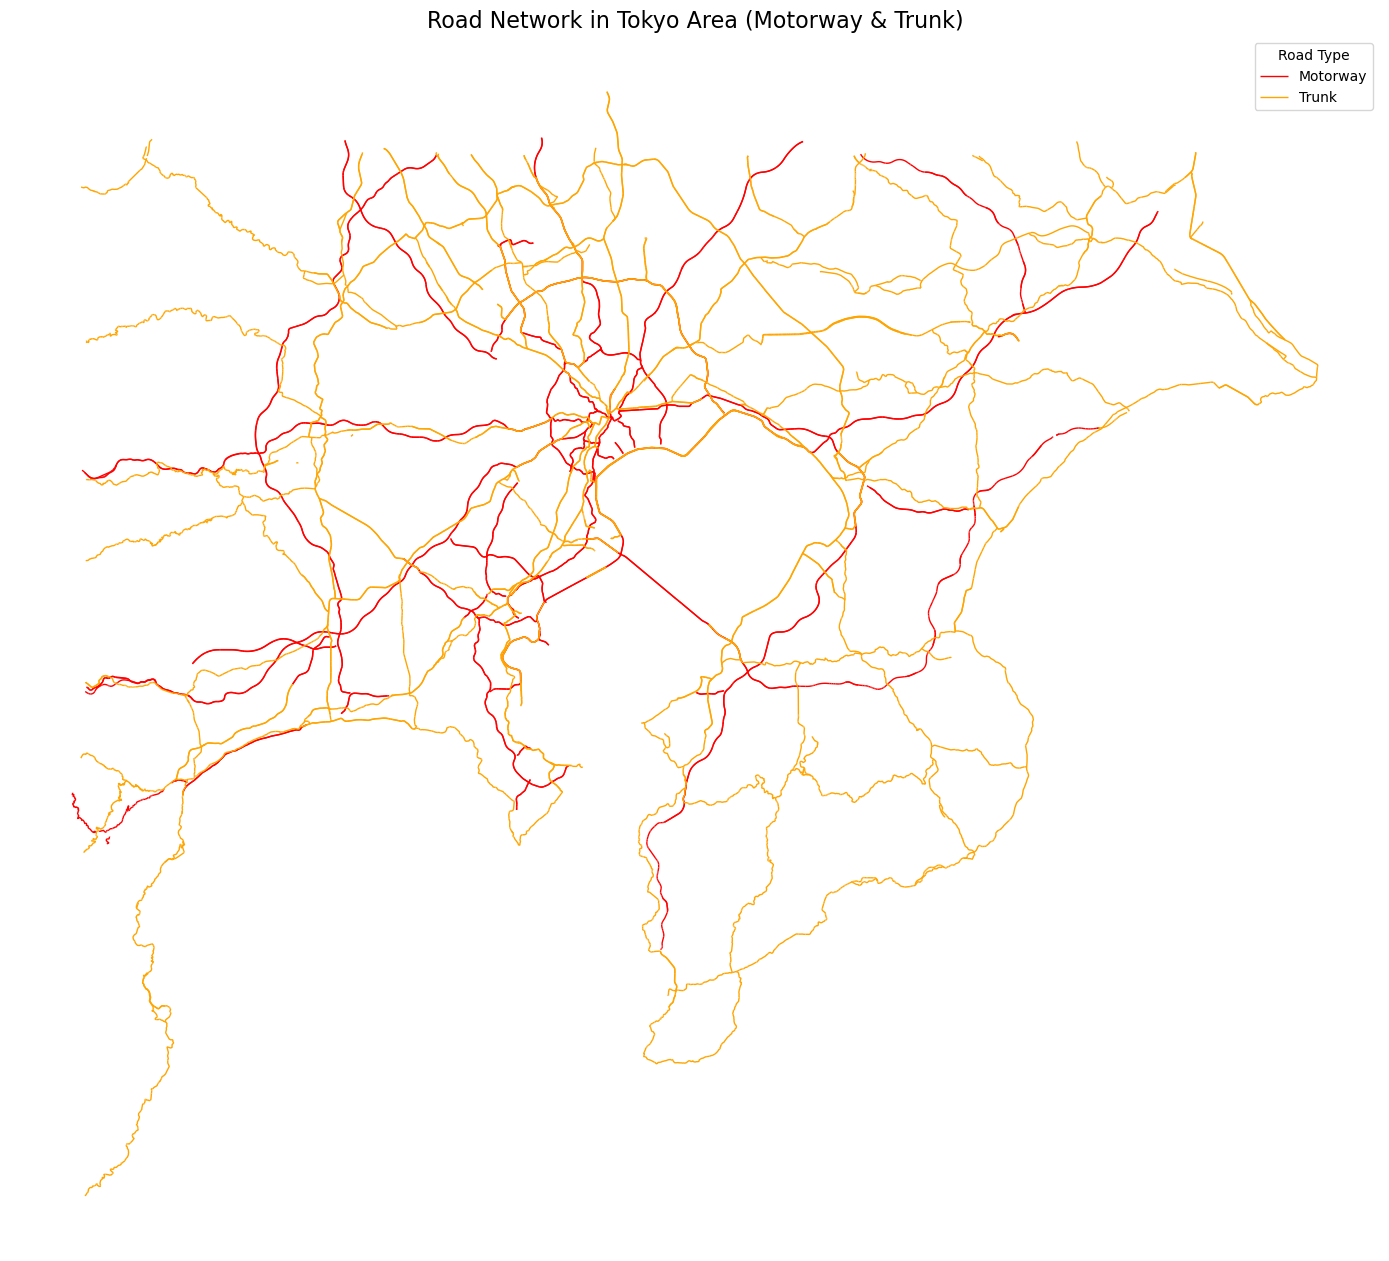

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

geojson_path = "./tokyo_motorway_trunk.geojson"

# 加载数据
gdf = gpd.read_file(geojson_path)

# 分类字段（Motorway / Trunk）
def classify_highway(highway):
    if isinstance(highway, list):
        highway = highway[0]
    if highway == 'motorway':
        return 'Motorway'
    elif highway == 'trunk':
        return 'Trunk'
    else:
        return 'Other'

gdf['type'] = gdf['highway'].apply(classify_highway)

# 设置颜色映射
color_map = {
    'Motorway': 'red',
    'Trunk': 'orange',
    'Other': 'gray'
}
gdf['color'] = gdf['type'].map(color_map)

# 绘图
fig, ax = plt.subplots(figsize=(14, 14))
for road_type in ['Motorway', 'Trunk']:
    subset = gdf[gdf['type'] == road_type]
    subset.plot(ax=ax, linewidth=1, color=color_map[road_type], label=road_type)

plt.title("Road Network in Tokyo Area (Motorway & Trunk)", fontsize=16)
plt.axis("off")
plt.legend(title="Road Type")
plt.tight_layout()
plt.savefig("tokyo_roads_en.png", dpi=300)  # 可选保存
plt.show()


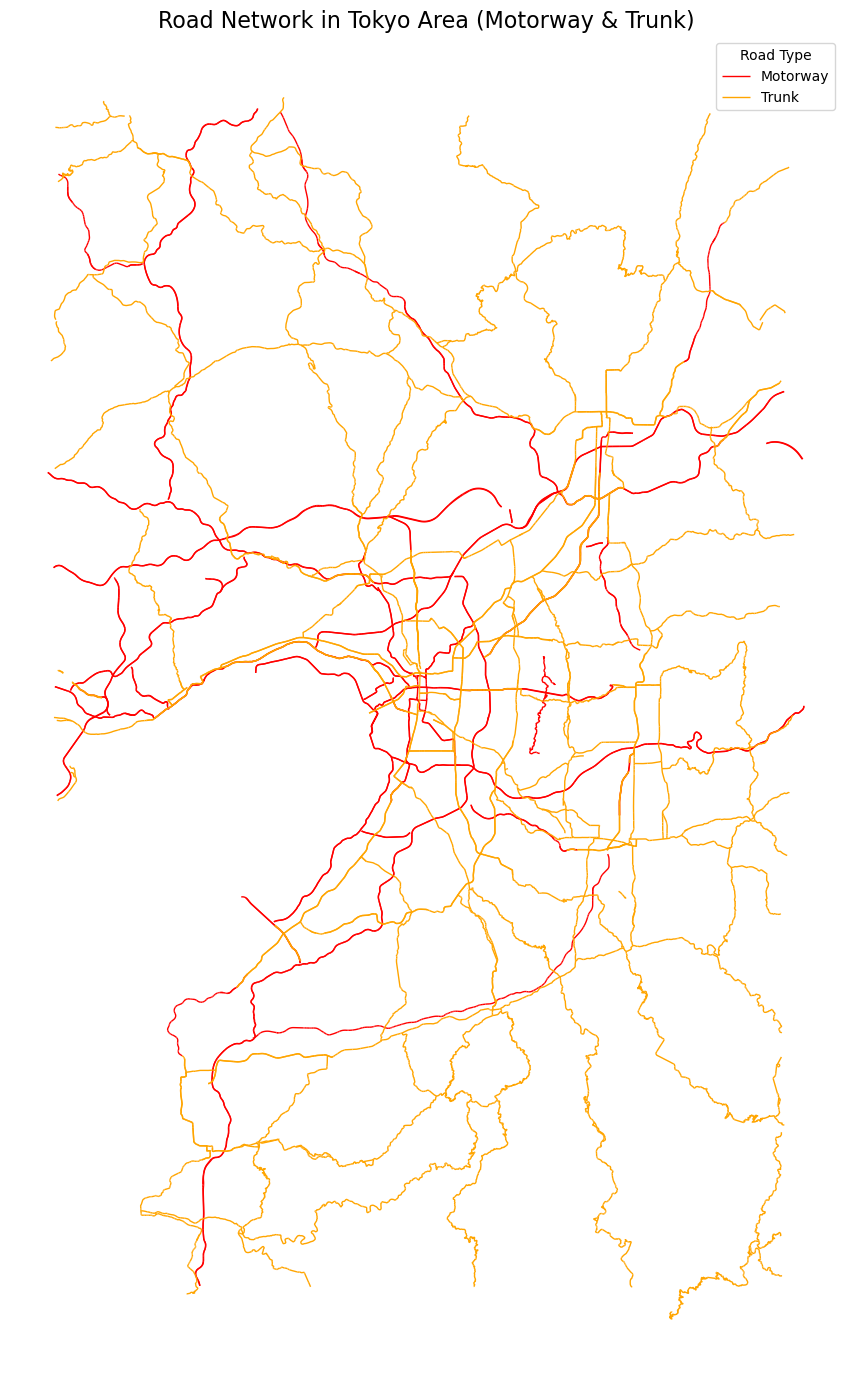

In [9]:

geojson_path = "./keihan_motorway_trunk.geojson"

# 加载数据
gdf = gpd.read_file(geojson_path)


# 分类字段（Motorway / Trunk）
def classify_highway(highway):
    if isinstance(highway, list):
        highway = highway[0]
    if highway == 'motorway':
        return 'Motorway'
    elif highway == 'trunk':
        return 'Trunk'
    else:
        return 'Other'


gdf['type'] = gdf['highway'].apply(classify_highway)

# 设置颜色映射
color_map = {
    'Motorway': 'red',
    'Trunk': 'orange',
    'Other': 'gray'
}
gdf['color'] = gdf['type'].map(color_map)

# 绘图
fig, ax = plt.subplots(figsize=(14, 14))
for road_type in ['Motorway', 'Trunk']:
    subset = gdf[gdf['type'] == road_type]
    subset.plot(ax=ax, linewidth=1, color=color_map[road_type], label=road_type)

plt.title("Road Network in Tokyo Area (Motorway & Trunk)", fontsize=16)
plt.axis("off")
plt.legend(title="Road Type")
plt.tight_layout()
plt.savefig("keihan_roads_en.png", dpi=300)  # 可选保存
plt.show()


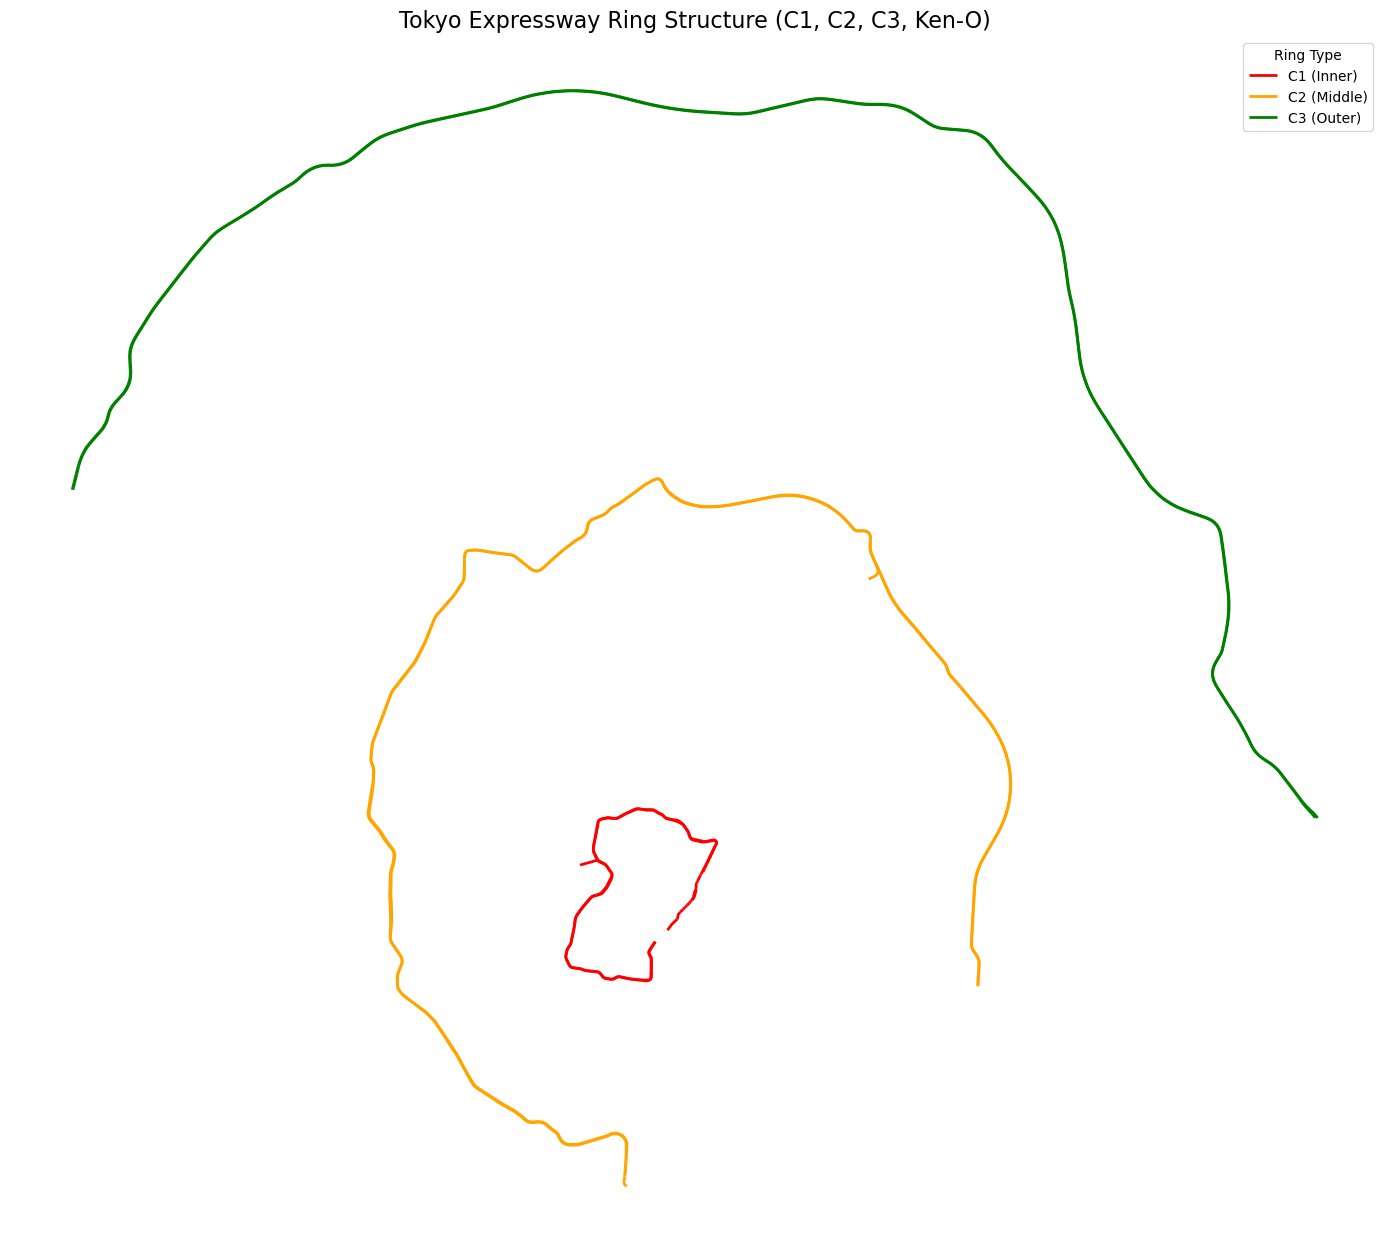

In [16]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 文件路径（根据你本地位置）
tokyo_path = "./tokyo_motorway_trunk.geojson"
keno_path = "./keno.geojson"

# 加载东京高速数据（C1~C3）
gdf_tokyo = gpd.read_file(tokyo_path)
gdf_tokyo = gdf_tokyo[gdf_tokyo['ref'].notnull()]  # 删除没有ref的

# 标记 C1 ~ C3
def extract_c_ring(ref_value):
    if isinstance(ref_value, list):
        ref_value = ref_value[0]
    if 'C1' in ref_value:
        return 'C1 (Inner)'
    elif 'C2' in ref_value:
        return 'C2 (Middle)'
    elif 'C3' in ref_value:
        return 'C3 (Outer)'
    else:
        return None

gdf_tokyo['ring_type'] = gdf_tokyo['ref'].apply(extract_c_ring)
gdf_tokyo = gdf_tokyo[gdf_tokyo['ring_type'].notnull()]  # 保留C1~C3

# 指定颜色映射
color_map = {
    'C1 (Inner)': 'red',
    'C2 (Middle)': 'orange',
    'C3 (Outer)': 'green',
    'Ken-O (Metropolitan)': 'blue'
}
gdf_tokyo['color'] = gdf_tokyo['ring_type'].map(color_map)

# 加载 Ken-O 数据（没有 ref 字段，我们手动添加标签）
gdf_keno = gpd.read_file(keno_path)
gdf_keno = gdf_keno[gdf_keno.geometry.notnull()]  # 删除空几何
gdf_keno['ring_type'] = 'Ken-O (Metropolitan)'
gdf_keno['color'] = color_map['Ken-O (Metropolitan)']

# 合并所有数据
gdf_all = gpd.GeoDataFrame(pd.concat([gdf_tokyo, gdf_keno], ignore_index=True), crs=gdf_tokyo.crs)

# 绘图
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_aspect("auto")

for ring_type, color in color_map.items():
    subset = gdf_all[gdf_all['ring_type'] == ring_type]
    if not subset.empty:
        subset.plot(ax=ax, linewidth=2, color=color, label=ring_type)

plt.title("Tokyo Expressway Ring Structure (C1, C2, C3, Ken-O)", fontsize=16)
plt.axis("off")
plt.legend(title="Ring Type")
plt.tight_layout()
plt.savefig("tokyo_4ring_expressways.png", dpi=300)
plt.show()


In [20]:
# draw_mst_expressway_overlay.py

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.affinity import scale, translate
import python_codes.files_operators as fo

from shapely.affinity import scale, translate

# 1. 计算 MST 的坐标范围
mst_coords = np.array([read_pos[v] for v in read_graph.vertices()])
mst_xmin, mst_ymin = np.min(mst_coords, axis=0)
mst_xmax, mst_ymax = np.max(mst_coords, axis=0)

# 2. 计算 GeoJSON 的边界
gdf_bounds = gdf.total_bounds  # [minx, miny, maxx, maxy]
geo_xmin, geo_ymin, geo_xmax, geo_ymax = gdf_bounds

# 3. 计算缩放因子和偏移量（大致对齐）
scale_x = (mst_xmax - mst_xmin) / (geo_xmax - geo_xmin)
scale_y = (mst_ymax - mst_ymin) / (geo_ymax - geo_ymin)
scale_factor = min(scale_x, scale_y)  # 取最小保持长宽比

# 4. 平移量（中心点对齐）
geo_center = [(geo_xmin + geo_xmax) / 2, (geo_ymin + geo_ymax) / 2]
mst_center = [(mst_xmin + mst_xmax) / 2, (mst_ymin + mst_ymax) / 2]
shift_x = mst_center[0] - geo_center[0] * scale_factor
shift_y = mst_center[1] - geo_center[1] * scale_factor

# 5. 应用变换到 GeoJSON 道路几何
gdf.geometry = gdf.geometry.apply(lambda geom: translate(scale(geom, xfact=scale_factor, yfact=scale_factor, origin=(0, 0)), xoff=shift_x, yoff=shift_y))
